In [1]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gzip
import shutil
import glob
import rioxarray as rxr
# from dask.distributed import Client
# c = Client(n_workers=os.cpu_count()-2, threads_per_worker=1)

In [2]:
# Set data directory
data_dir = "../../../datasets/et/lsa_saf"

In [3]:
# Read AOI vector file

gha_region = "../../../datasets/gha/gha.shp"

## Evapotranspiration pre-processing

### Read Evapotranspiration file

In [4]:
''''
Study period: 2004 - 2024
'''

# Find all NetCDF files in the directory
all_files = glob.glob(data_dir + '/*.nc')

# Sort the file by the date
all_files.sort()

In [5]:
(all_files[-12:])

['../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412200000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412210000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412220000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412230000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412240000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412250000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412260000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412270000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412280000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412290000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_202412300000.nc',
 '../../../datasets/et/lsa_saf/NETCDF4_LSASAF_MSG_DMETv3_MSG-Disk_2024123100

In [6]:
file = xr.open_mfdataset(all_files, combine='by_coords')

In [7]:
file

<xarray.Dataset>
Dimensions:                 (time: 7500, lat: 3201, lon: 3201)
Coordinates:
  * lat                     (lat) float32 80.0 79.95 79.9 ... -79.9 -79.95 -80.0
  * lon                     (lon) float32 -80.0 -79.95 -79.9 ... 79.9 79.95 80.0
  * time                    (time) datetime64[ns] 2004-01-21 ... 2024-12-31
Data variables:
    ET                      (time, lat, lon) float64 dask.array<chunksize=(1, 3201, 3201), meta=np.ndarray>
    crs                     (time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    max_nslots_missing      (time, lat, lon) float64 dask.array<chunksize=(1, 3201, 3201), meta=np.ndarray>
    missing_values_percent  (time, lat, lon) float64 dask.array<chunksize=(1, 3201, 3201), meta=np.ndarray>
Attributes: (12/27)
    date_created:               2023-03-06T11:15:29Z
    algorithm_version:          2.0.1
    base_algorithm_version:     0.5.4
    processing_level:           04
    platform:                   MSG1
    sensor:                     SEVI
    ...                         ...
    westernmost_longitude:      80.0
    spatial_resolution:          0.05x 0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    Conventions:                CF-1.6
    netcdf_version_id:          netCDF4

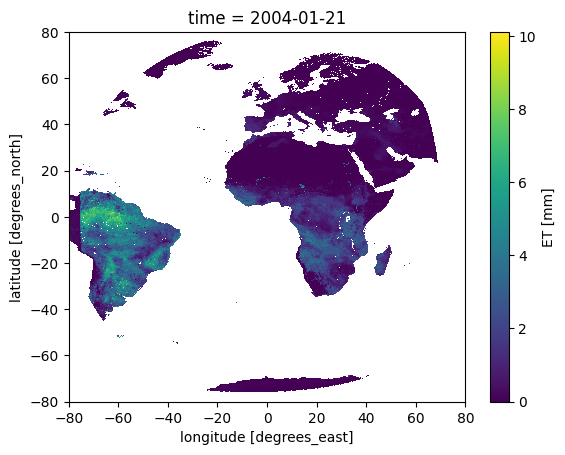

In [8]:
# Visualise a sample month
sample = xr.open_dataset(all_files[0])
sample['ET'].plot()

#### Open and concatenate the netcdf file

In [9]:
# # Assuming all your files have a common prefix or pattern
# ds = xr.open_mfdataset('*.nc', combine='by_coords')  # Opens all matching files

# # Calculate monthly means
# monthly_mean = ds.resample(time='1M').mean()



In [10]:
# # Save the result
# monthly_mean.to_netcdf('monthly_mean_et.nc')

In [11]:
# # Concatenate the all the netcdf files in batches
# combine_et = xr.open_mfdataset(all_files, combine = 'nested', concat_dim="time")
# combine_et

In [12]:
# # Find the mean
# monthly_scale_et = file.resample(time='MS').mean()
# monthly_scale_et

In [13]:
dates = [i for i in file.ET.time.values]

In [15]:

gha_region = gpd.read_file(gha_region)
gha_region[:5]

,OBJECTID,COUNTRY,area,Shape_Leng,Shape_Area,land_under,geometry
0,1,Burundi,0.0,8.560371,2.193095,None,"POLYGON ((30.36003 -2.35343, 30.36209 -2.35250..."
1,2,Djibouti,0.0,7.874779,1.781569,None,"POLYGON ((42.66339 11.07150, 42.65628 11.07671..."
2,3,Eritrea,0.0,41.125347,10.077064,None,"MULTIPOLYGON (((43.14681 12.71384, 43.14167 12..."
3,4,Ethiopia,0.0,49.028874,92.986294,None,"POLYGON ((41.77824 11.54207, 41.77785 11.51077..."
4,5,Kenya,0.0,40.625985,47.319578,None,"MULTIPOLYGON (((39.40283 -4.65471, 39.40523 -4..."


In [16]:
# Set spatial dimensions and CRS
data = file.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data = data.rio.write_crs("epsg:4326", inplace=True)

# Load the shapefile using geopandas
gdf = gha_region.to_crs(data.rio.crs)

# Extract geometries from the GeoDataFrame
geometries = gdf.geometry

# Clip the dataset using the geometries
gha_eta = data.rio.clip(geometries, gdf.crs)

In [17]:
gha_eta

<xarray.Dataset>
Dimensions:                 (lat: 697, lon: 592, time: 7500)
Coordinates:
  * lat                     (lat) float32 23.1 23.05 23.0 ... -11.6 -11.65 -11.7
  * lon                     (lon) float32 21.85 21.9 21.95 ... 51.3 51.35 51.4
  * time                    (time) datetime64[ns] 2004-01-21 ... 2024-12-31
    crs                     int64 0
Data variables:
    ET                      (time, lat, lon) float64 dask.array<chunksize=(1, 697, 592), meta=np.ndarray>
    max_nslots_missing      (time, lat, lon) float64 dask.array<chunksize=(1, 697, 592), meta=np.ndarray>
    missing_values_percent  (time, lat, lon) float64 dask.array<chunksize=(1, 697, 592), meta=np.ndarray>
Attributes: (12/27)
    date_created:               2023-03-06T11:15:29Z
    algorithm_version:          2.0.1
    base_algorithm_version:     0.5.4
    processing_level:           04
    platform:                   MSG1
    sensor:                     SEVI
    ...                         ...
    westernmost_longitude:      80.0
    spatial_resolution:          0.05x 0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    Conventions:                CF-1.6
    netcdf_version_id:          netCDF4

In [18]:
# Remove grid attribute

# Create a copy or use a new dataset if needed
gha_eta_modified = gha_eta.copy()

for var_name in gha_eta_modified.data_vars:
    if 'grid_mapping' in gha_eta_modified[var_name].attrs:
        del gha_eta_modified[var_name].attrs['grid_mapping']

# Now gha_eta_modified is your dataset without grid_mapping attributes

In [19]:
gha_eta_modified.data_vars['ET']

<xarray.DataArray 'ET' (time: 7500, lat: 697, lon: 592)>
dask.array<getitem, shape=(7500, 697, 592), dtype=float64, chunksize=(1, 697, 592), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 23.1 23.05 23.0 22.95 ... -11.55 -11.6 -11.65 -11.7
  * lon      (lon) float32 21.85 21.9 21.95 22.0 22.05 ... 51.25 51.3 51.35 51.4
  * time     (time) datetime64[ns] 2004-01-21 2004-01-22 ... 2024-12-31
    crs      int64 0
Attributes:
    long_name:  ET
    units:      mm

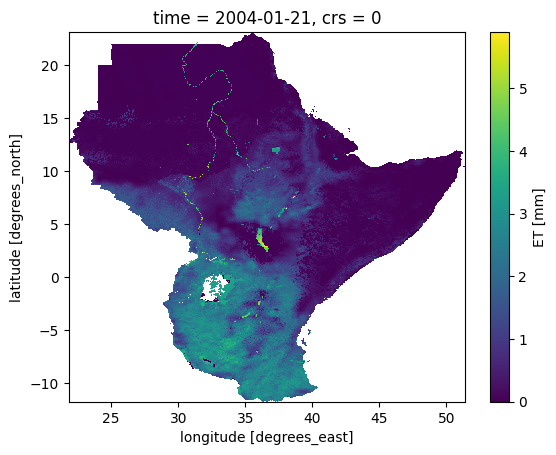

In [20]:
# Plot the clipped data

gha_eta_modified.ET.isel(time=0).plot()

In [ ]:
# Save the clipped data to a new NetCDF file
gha_eta_modified.to_netcdf('daily_et_gha.nc')